In [21]:
import os
import numpy as np
from scipy import signal

import pandas as pd
from scipy import stats

import os
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import trompy as tp

# %run "..//src//vgp_helper_fx"

In [22]:
def get_number_cells (s2p_folder):
    iscell = np.load(os.path.join(s2p_folder, 'iscell.npy'))
    return sum(iscell[:,0])


def load_s2p_data(s2p_folder):
    raw_F = np.load(os.path.join(s2p_folder, 'F.npy'))
    neu_F = np.load(os.path.join(s2p_folder, 'Fneu.npy'))
    iscell = np.load(os.path.join(s2p_folder, 'iscell.npy'))
    s2p_length=len(raw_F[0,:])
    return raw_F, neu_F, iscell, s2p_length


In [23]:
def get_frames(events_file,s2p_length):
    df = pd.read_csv(events_file)

    pump_frames = list(df[df['Item1'] == 'pump_on']['Item2.Item2'])
    pump_frames=[frame for frame in pump_frames if frame < s2p_length-100] #removes event if too close to the end

    licks_frames = list (df[df['Item1']== 'Lick']['Item2.Item2'])
    licks_frames=[frame for frame in licks_frames if frame < s2p_length-100] #removes event if too close to the end
    
    return pump_frames, licks_frames

In [24]:
def process_cell(cell_idx, raw_F, neu_F, filter=True, normalization_method="vijay"):
    x = raw_F[cell_idx, :] - 0.7*(neu_F[cell_idx, :])
    
    if normalization_method == "zscore":
        x = (x - np.mean(x))/np.std(x)
    elif normalization_method == "vijay":
        x = (x - np.median(x)) / (np.max(x) - np.min(x))
    else:
        print(f"{normalization_method} is not a valid normalization method")
        
    if filter:
        x = filter_cell(x, rolling_average=True)
    return x


In [25]:

def filter_cell(x, rolling_average=True):
    if rolling_average:
        window_size = 3

        # Calculate the rolling average
        filtered = np.convolve(x, np.ones(window_size) / window_size, mode='valid')
    else:
        t = np.arange(0,len(x)/10,0.1)
        filt = signal.butter(4, 1, 'low', fs=10, output='sos')
        filtered = signal.sosfilt(filt, x)
    return filtered

In [26]:
def get_snips(f, event_frames, baseline_frames=50, total_frames=150):
    snips = []
    for frame in event_frames:
        snips.append(f [frame - baseline_frames : frame + (total_frames - baseline_frames)])

    return np.array(snips)

In [27]:
def get_responsive(snips, range1=range(30,50), range2=range(50,70)):
    pre = np.mean(snips[:, range1], axis=0)
    post = np.mean(snips[:, range2], axis=0)
    
    return stats.ttest_rel(pre, post)


In [28]:
def get_licks_per_trial(pump_frames, licks_frames, trial_end=100):

    licks_per_trial=[]
    for p in pump_frames: 
        temp=[]
        for l in licks_frames: 
            if l > p and l < p + trial_end: 
                temp.append(l)                
        licks_per_trial.append(temp)

    return licks_per_trial


In [84]:
def get_first_lick(licks_per_trial):
    
    first_licks=[]
    empty_lick=[]
    for trial in licks_per_trial:
        if len(trial) > 0:
            first_licks.append(trial[0])
        if len (trial) > 4:
            empty_lick.append(trial[4])

    return first_licks, empty_lick

In [85]:
def get_ncells_overlap(cond1, cond2):
    
    n_both = sum(np.logical_and(cond1, cond2))
    n_neither = sum(~np.logical_or(cond1, cond2))
    n_cond1 = int(sum(cond1) - n_both)
    n_cond2 = int(sum(cond2) - n_both)
    
#     print(n_cond1, n_cond2, n_both, n_neither)

    return (int(sum(cond1)), int(sum(cond2)), n_cond1, n_cond2, n_both, n_neither)

In [86]:
def make_responsive_df(pump_responsive, lick_responsive):
    pump_r = abs(pump_responsive)
    lick_r = abs(lick_responsive)

    # activated cells
    pump_a = pump_responsive == 1
    lick_a = lick_responsive == 1

    # inhibited cells
    pump_i = pump_responsive == -1
    lick_i = lick_responsive == -1
#     print(pump_r)
#     print(pump_a)
#     print(pump_i)

    return pd.DataFrame([
                    get_ncells_overlap(pump_r, lick_r),
                    get_ncells_overlap(pump_a, lick_a),
                    get_ncells_overlap(pump_i, lick_i)],
                    columns=['pump_all','lick_all',"pump_only", "lick_only", "both", "neither"],
                    index=["responsive", "activated", "inhibited"]).T

In [87]:
def assemble_data(s2p_folder,events_file,
                  animal="unnamed", diet="ns", solution="ns",
                  baseline_frames=50, total_frames=150):

    raw_F, neu_F, iscell, s2p_length = load_s2p_data(s2p_folder)
    
    pump_frames, licks_frames= get_frames(events_file,s2p_length)
    
    cell_idx = [idx for idx,vals in enumerate(iscell) if vals[0]==1]

    pump_snips_all = []
    lick_snips_all = []
    empy_lick_snips_all = [] # adding list 
    pump_responsive = np.zeros(len(cell_idx))
    lick_responsive = np.zeros(len(cell_idx))

    for i, cell in enumerate(cell_idx):
        delta_f = process_cell(cell, raw_F, neu_F)

        pump_snips = get_snips(delta_f, pump_frames, baseline_frames=baseline_frames, total_frames=total_frames)
        r, p = get_responsive(pump_snips)

        if (p < 0.05) & (r < 0):
            pump_responsive[i] = 1
        elif (p < 0.05) & (r > 0):
            pump_responsive[i] = -1

        licks_per_trial = get_licks_per_trial(pump_frames, licks_frames, trial_end=total_frames-baseline_frames)
        first_lick_frames, empty_licks_frames = get_first_lick(licks_per_trial)# Added 'empty' licks (10 licks after the first lick of the trial)

        lick_snips = get_snips(delta_f, first_lick_frames, baseline_frames=baseline_frames, total_frames=total_frames)
        empty_lick_snips = get_snips(delta_f, empty_licks_frames, baseline_frames=baseline_frames, total_frames=total_frames) #getting snips from empty licks
        r, p = get_responsive(lick_snips)

        if (p < 0.05) & (r < 0):
            lick_responsive[i] = 1
        elif (p < 0.05) & (r > 0):
            lick_responsive[i] = -1

        pump_snips_all.append(pump_snips)
        lick_snips_all.append(lick_snips)
        empy_lick_snips_all.append(empty_lick_snips) # appending snips

    df_responsive = make_responsive_df(pump_responsive, lick_responsive)

    return {"animal": animal,
            "diet": diet,
            "solution": solution,
            "raw_F": raw_F,
            "neu_F": neu_F,
            "iscell": iscell,
            "pump_snips_all": np.array(pump_snips_all),
            "pump_responsive": pump_responsive,
            "lick_snips_all": np.array(lick_snips_all),
            "empty_lick_snips_all": np.array(empty_lick_snips),
            "lick_responsive": lick_responsive,
            "df_responsive": df_responsive,
            "licks_trial":licks_per_trial
            }
        

In [88]:
DATA_FOLDER = "D:\VGP"

#casein session 1
animal="VGP402"
day="030"
day_meta='C2'
date="20230320"



s2p_folder = os.path.join(DATA_FOLDER,
                          "2P",
                          "proc_s2p\\"
                          "sub-{}\\ses-{}-{}\\suite2p\\plane0"
                          .format(animal, day, date))

# to get event file in single folder
# rows,header=tp.metafilereader('C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\GitHub\\2P\\Metafile_VGP2.4.xls',sheetname='analysis')
rows,header=tp.metafilereader('C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\GitHub\\2P\\VGP2\\Metafile_VGP2.4.xls',sheetname='analysis')
folder= "D:\\VGP\\Bonsai\\"

for row in rows: 
    if row[0]== animal and row[3] == day_meta: 
        events_file=folder+row[6]
C1 = assemble_data(s2p_folder,events_file,animal="VGP118", diet="NR", solution="Casein")


File is excel file. Making csv metafile first


In [101]:
x=C1['empty_lick_snips_all']

In [104]:
y1 = np.mean(x, axis=0)

In [107]:
y1

array([-0.02105986, -0.01457898,  0.08975238,  0.17613033,  0.12530704,
        0.05020406,  0.05452923,  0.0633479 ,  0.13035708,  0.11584595,
        0.22541113,  0.27921635,  0.35308258,  0.2820935 ,  0.21381837,
        0.11395133,  0.08392422,  0.13005991,  0.10746186,  0.05061116,
       -0.03703618, -0.04229062, -0.06069921, -0.05596523, -0.07214252,
       -0.03954745,  0.01393484, -0.0311376 , -0.04243147, -0.1055638 ,
       -0.03737285, -0.03167008, -0.01800407,  0.03456441,  0.02508271,
        0.06234304,  0.00333663,  0.05483498,  0.05469928,  0.1258464 ,
        0.13241316,  0.14625782,  0.09469592,  0.12115536,  0.08609368,
        0.13683452,  0.07822661,  0.08373184,  0.04822871,  0.02512221,
        0.06535246,  0.03984805,  0.031555  , -0.03997001, -0.04709159,
       -0.03761848, -0.02341826, -0.04460436, -0.00675829, -0.01935762,
        0.04655223,  0.0093503 , -0.01528151, -0.0957523 , -0.10675245,
       -0.04205186,  0.05453782,  0.10836193,  0.08492564,  0.07

<AxesSubplot:>

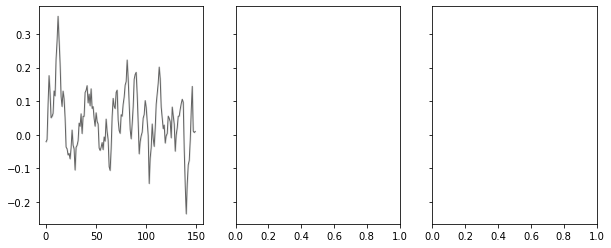

In [109]:
f, ax = plt.subplots(figsize=(10,4),ncols=3, sharey=True)
tp.shadedError(ax[0], x, linecolor="#636363")
